In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
import io, requests, sys, urllib.request
sys.setrecursionlimit(3000)

In this homework, you will implement *two more compression algorithms*:

1. a "universal" compression algorithm for binary pictures (which is essentially the one discussed in the tutorials), and
2. the Lempel-Ziv algorithm discussed in the lecture (we will use it to compress the same Hamlet text as on the previous homework).

The two problems can be solved independently from each other, so **feel free to start with the one that seems easiest!**

# 1. "Universal" Compression of Bitstrings and Binary Pictures

## Enumerating Bitstrings

Before we start, let us agree how to order $B(N, k)$ -- the set of *all* bitstrings of length $N$ with $k$ ones and (hence) $N-k$ zeros.
We will use the *lexicographic order* discussed in the exercise class, which is just the order in which the bitstrings would appear in a dictionary.
For example, $B(4,2)$ is sorted as follows:
```
0011
0101
0110
1001
1010
1100
```
The following function computes $B(N,k)$ in lexicographic order:

In [ ]:
def B(N, k):
    if N == 0:
        return [[]] if k == 0 else []

    return [[0] + y for y in B(N - 1, k)] + [[1] + y for y in B(N - 1, k - 1)]


B(4, 2)

[[0, 0, 1, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 1, 0, 0]]

For simplicity, we represent bitstrings by Python lists, which is very inefficient. In a real implementation you would use a more compact representation.

The size of the list $B(n,k)$ is given by the binomial coefficient $\binom N k$:

In [ ]:
def binomial(N, k):
    if 0 <= k <= N:
        return factorial(N) // factorial(k) // factorial(N - k)
    return 0


binomial(4, 2)

6

Here comes your first task.
Consider the following two functions.
The first function, `bitstring_to_index`, determines the index of a given bitstring of length $N$ with $k$ ones in the list $B(N,k)$.
The second function, `index_to_bitstring`, looks up the bitstring for a given index.
While correct, these functions are completely impractical since they both create the entire list $B(N,k)$ even though we are only interested in a single element.
For example, $B(64, 8)$ contains $\approx 2^{32}$ elements, which requires multiple GB!

**Your task is to do better and re-implement the two functions `bitstring_to_index` and `index_to_bitstring` in an efficient way (in the tutorials you discussed how this can be done)!**

In [ ]:
def index_to_bitstring(N, k, index):
    # TODO: CAN YOU MAKE THIS FASTER?
    return B(N, k)[index]


def bitstring_to_index(x):
    # TODO: CAN YOU MAKE THIS FASTER?
    N = len(x)
    k = list(x).count(1)
    return B(N, k).index(x)


# a simple test
assert bitstring_to_index([1, 0, 1, 0]) == 4
assert index_to_bitstring(4, 2, 4) == [1, 0, 1, 0]

Here is a more elaborate test to make sure that your implementation works fine:

In [ ]:
for N in range(11):
    for k in range(N + 1):
        for index, x in enumerate(B(N, k)):
            assert bitstring_to_index(x) == index
            assert index_to_bitstring(N, k, index) == x

The following test will fail unless you re-implemented the two functions more efficiently:

In [ ]:
assert bitstring_to_index(index_to_bitstring(64, 8, 986860893)) == 986860893

## Compressing and Decompressing Images

We will now implement the "universal" compression algorithm discussed in the tutorials to compress images.
Consider a binary image of height $h$ and width $w$.
Any such image can be converted into a bitstring by listing the pixel values (0=black pixel, 1=white pixel) row by row, starting with the top row.
Let $N$ denote the length of the bitstring, $k$ the number of ones, and $p$ its index in the lexicographically ordered list $B(N,k)$.
Then the quadruple $(h,w,k,p)$ defines the **compression** of the bitstring.

For example, consider the following $2\times2$ image:

![](https://github.com/qi-rub/iit21-homework/raw/main/material/two_by_two.png)

It corresponds the bitstring `0010`, so $N=4$ and $k=1$.
There are four strings in $B(4, 1)$.
In lexicographic order, they are: `0001`, `0010`, `0100`, `1000`.
The index of our bitstring in this list is $p=1$ (remember that indices start at 0).
Thus, the compression of this image is $(2,2,1,1)$.

**Your task is to program both the compressor and the decompressor.
For this, please complete the following two functions.
As usual, images are represented by two-dimensional NumPy arrays.
Don't worry about converting $(w,h,k,p)$ to bitstrings -- you can keep them as integers.**

In [ ]:
def compress(image):
    # TODO: FINISH THIS FUNCTION
    h, w = image.shape
    x = list(image.reshape(h * w))
    k = ...
    p = ...
    return h, w, k, p


def decompress(h, w, k, p):
    # TODO: FINISH THIS FUNCTION
    x = ...
    return np.array(x).reshape(h, w)


# make sure the code works for the 2x2 example described above
TEST_IMAGE = np.array([[0, 0], [1, 0]])
assert compress(TEST_IMAGE) == (2, 2, 1, 1)
assert np.all(decompress(2, 2, 1, 1) == TEST_IMAGE)

Here is a more interesting test.
Does your code decompress the following image correctly? (You will recognize when it does.)

In [ ]:
# decompress an 8x8 image
image = decompress(8, 8, 8, 986860893)

# show it
plt.imshow(image, cmap=plt.get_cmap("binary"), interpolation="none")
plt.show()

Finally, you may evaluate your compressor on the donkey image from the first homework. The following code downloads the image and downscales it to 34x40 pixels (to avoid any potential performance problems):

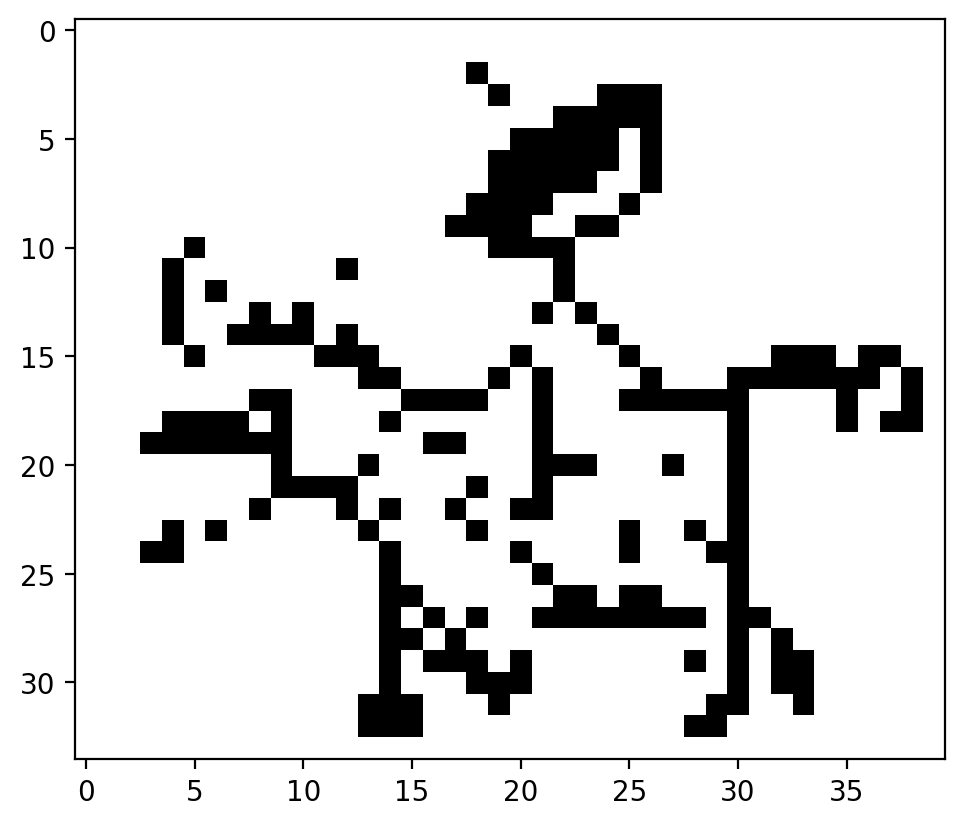

In [ ]:
URL = "https://github.com/qi-rub/it-ss23-homework/raw/main/material/donkey.png"
ORIGINAL = plt.imread(io.BytesIO(urllib.request.urlopen(URL).read()))

# remove alpha channel
if ORIGINAL.shape[2] == 4:
    alpha = ORIGINAL[:, :, 3:]
    ORIGINAL = ORIGINAL[:, :, :3] * alpha + (1 - alpha)

# convert to black & white
WHITE_THRESHOLD = 0.8
ORIGINAL = np.where(ORIGINAL[:, :, :3].max(axis=2) > WHITE_THRESHOLD, 0, 1)

# downscale by a factor 20
ORIGINAL = ORIGINAL[::20, ::20]

# show the figure
plt.imshow(ORIGINAL, cmap=plt.get_cmap("binary"), interpolation="none")
plt.show()

**Run the following code that first compresses and then decompresses the image -- does it pass the test?**

In [ ]:
h, w, k, p = compress(ORIGINAL)
assert np.all(ORIGINAL == decompress(h, w, k, p))

What compression rate does your code achieve on the donkey image?
(For simplicity, we will ignore the number of bits required to represent $h$ and $w$.
The original, uncompressed image contains $N = h \times w$ many bits, while, after compressing, we need about $\log(N) +\log\#B(N,k)$ bits to represent $k$ and $p$ in binary.

**Run the following code to determine the compression rate that you achieved for the donkey image:**

In [ ]:
N = h * w
R = (np.log2(N) + np.log2(float(binomial(N, k)))) / N
print(f"Compression rate: {R:2.0%}")

If you are interested, you could compare this number with the compression rate that PNG or GIF achieve for the same picture...

# 2. Lempel-Ziv Compression

Next, you will implement the Lempel-Ziv compression algorithm discussed in class.

Just like on the last homework, we are going to compress Shakespear's Hamlet, so let us download it again.

In [ ]:
hamlet = requests.get(
    "https://github.com/qi-rub/it-ss23-homework/raw/main/material/hamlet.txt"
).content.decode("ascii", errors="ignore")
hamlet = hamlet
len(hamlet)

179096

**Write a function that takes as input a string and as output returns the LZ compression as a list of pairs `(k,x)`. You can assume that the last symbol of the input is the symbol `EOF` defined below (in class we used $\perp$).**

In [ ]:
EOF = "\0"


def lz_compress(s):
    assert s.find(EOF) == len(s) - 1, "String should contain EOF precisely at the end"
    # TODO: can you implement this?
    return ...

The following code tests your function with the example discussed in class:

In [ ]:
compressed = lz_compress("ABBABAABAABABA" + EOF)
assert compressed == [
    (0, "A"),
    (0, "B"),
    (2, "A"),
    (3, "A"),
    (4, "B"),
    (1, "B"),
    (1, EOF),
]

Just like on the previous homework, we provide a decompressor for your convenience:

In [ ]:
def lz_decompress(compressed):
    phrases = [""]
    result = ""
    for k, x in compressed:
        phrase = phrases[k] + x
        phrases.append(phrase)
        result += phrase
    return result

Let's now compress Hamlet and estimate the compression rate:

In [ ]:
compressed = lz_compress(hamlet + EOF)
assert lz_decompress(compressed) == hamlet + EOF

compressed_bytes = np.ceil(
    sum(np.ceil(np.log2(j)) + 8 for j in range(1, len(compressed) + 1)) / 8
)
R = compressed_bytes / len(hamlet + EOF)
print(f"Compression rate: {R:2.0%}")

**Bonus challenges for the LZ problem (completely optional):**

0. Compare your results with `zlib`, a compression library that is shipped with Python (`import zlib; zlib.compress(...)`).
1. Modify your compressor so that it emits a bitstring, not just a list of pairs $(k,x)$. We discussed in class how this can be done.
2. Can you combine the LZ algorithm with Huffman compression to get an improved compression rate? Should you apply Huffman before or after the LZ step? It may be useful to use multiple Huffman codebooks for different kinds of data. Try to get below 50%!
3. Can you tweak your implementation so that it efficient enough for the `enwik8` data set mentioned on the last homework?